In [1]:
from mindspore import nn, ops, Tensor, jit_class, set_context, set_seed, jacrev
import mindspore as ms
import numpy as np

set_seed(123456)

In [2]:
set_context(mode=ms.PYNATIVE_MODE, device_target="GPU")

In [3]:
from mindspore.common.initializer import Normal

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        neuron = 256
        self.fc1 = nn.Dense(1, neuron)
        self.fc2 = nn.Dense(neuron, neuron)
        self.fc3 = nn.Dense(neuron, neuron)
        self.fc4 = nn.Dense(neuron, neuron)
        self.fc5 = nn.Dense(neuron, neuron)
        self.fcout = nn.Dense(neuron, 1)
        self.act = ops.Sin()

    def construct(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        x = self.fcout(x)

        return x

model = Network()
model

Network<
  (fc1): Dense<input_channels=1, output_channels=256, has_bias=True>
  (fc2): Dense<input_channels=256, output_channels=256, has_bias=True>
  (fc3): Dense<input_channels=256, output_channels=256, has_bias=True>
  (fc4): Dense<input_channels=256, output_channels=256, has_bias=True>
  (fc5): Dense<input_channels=256, output_channels=256, has_bias=True>
  (fcout): Dense<input_channels=256, output_channels=1, has_bias=True>
  >

In [4]:
samples = 2**15

class MyIterable:
    def __init__(self):
        
        self._index = 0
        self._data = np.random.uniform(-np.pi, np.pi, size=(samples, 1)).astype(np.float32)
        _ic = np.random.randint(-1, 2, (samples, 1))*np.pi
        self._ic = _ic.astype(np.float32)

    def __next__(self):
        if self._index >= len(self._data):
            raise StopIteration
        else:
            item = (self._data[self._index], self._ic[self._index])
            self._index += 1
            return item
        
    def __iter__(self):
        self._index = 0
        return self
    
    def __len__(self):
        return len(self._data)
    
dataset = ms.dataset.GeneratorDataset(source=MyIterable(), column_names=["data", "label"])
for batch, data in dataset.create_tuple_iterator():
    print(batch, data)
    break

[-0.30551064] [-3.1415927]


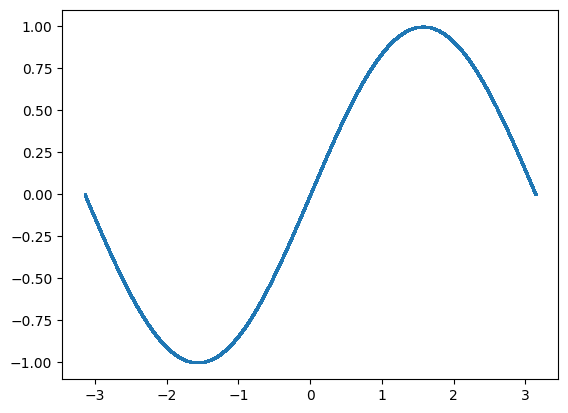

In [5]:
from matplotlib import pyplot as plt
test_data = np.random.uniform(-np.pi, np.pi, size=(2**17, 1)).astype(np.float32)
test_label = np.sin(test_data)
plt.scatter(test_data, test_label, s=1)
plt.show()

In [6]:


class SimplyGradient(nn.Cell):
    def __init__(self, net, order):
        super().__init__()
        self.net = net
        self.order = order - 1

    def construct(self, x):
        return self.net(x).sum(axis=self.order)


@jit_class
class MyLossFun:
    def __init__(self, net):
        self.net = net
        self.reduce_mean = ops.ReduceMean()
        self.loss_fn = nn.MSELoss()
        self.first_grad = jacrev(SimplyGradient(self.net, 1))

    def compute_loss(self, pde_data, ic_data):
        pde_loss = self.loss_fn(self.pde(pde_data), Tensor(np.array([0.0]).astype(np.float32), ms.float32))
        ic_loss = self.loss_fn(self.ic(ic_data), Tensor(np.array([0.0]).astype(np.float32), ms.float32))

        # pde_loss = self.loss_fn(self.net(pde_data), ops.sin(pde_data))
        # ic_loss = self.loss_fn(self.net(ic_data), Tensor(np.array([0.0]).astype(np.float32), ms.float32))

        return pde_loss + ic_loss

    def pde(self, data):
        du_dx = self.first_grad(data)[0]
        pde_res = du_dx - ops.cos(data)

        return pde_res

    def ic(self, data):
        out = self.net(data)
        return out 


In [7]:
optimizer = nn.Adam(model.trainable_params(), learning_rate=1e-3)
loss_fn = MyLossFun(model)

In [8]:
batch_size=2**5
dataset = dataset.batch(batch_size=batch_size)

In [9]:
def train_loop(model, dataset, loss_fn, optimizer):
    def forwad_fn(pde_data, ic_data):
        # logits = model(pde_data)
        loss = loss_fn.compute_loss(pde_data, ic_data)
        return loss
    
    grad_fn = ops.value_and_grad(forwad_fn, None, optimizer.parameters, has_aux=False)
    
    @ms.jit
    def train_step(pde_data, ic_data):
        loss, grads = grad_fn(pde_data, ic_data)
        loss = ops.depend(loss, optimizer(grads))
        return loss
    
    size = dataset.get_dataset_size()
    print(size)
    model.set_train()
    for batch, (pde_data, ic_data) in enumerate(dataset.create_tuple_iterator()):
        # print(data.shape, "  ", label.shape)
        loss = train_step(pde_data, ic_data)
        # print(loss)

        if batch % 100 == 0:
            loss, current = ops.ReduceMean()(loss).asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")
        

In [10]:
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for pde_data, ic_data in dataset.create_tuple_iterator():
        total += 2*len(pde_data)
        pred_pde = model(pde_data)
        pred_ic = model(ic_data)
        test_loss += loss_fn.compute_loss(pde_data, ic_data).asnumpy()
        correct += (ops.isclose(pred_pde, ops.sin(pde_data), rtol=1e-2, atol=1e-8)).asnumpy().sum()
        correct += (ops.isclose(pred_ic, ops.sin(ic_data), rtol=1e-2, atol=1e-8)).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
import time
for epoch in range(5):
    print("epoch: ", epoch + 1)
    time_beg = time.time()
    train_loop(model, dataset, loss_fn, optimizer)
    time_cost = time.time()-time_beg
    mean_step_cost = time_cost * batch_size / samples * 1000 
    print(f"Train: \n time cost: {time_cost:>4f}s\nmean step time cost: {mean_step_cost:>5f}ms" )
    # test_loop(model, dataset, loss_fn)
    print("="*100)

epoch:  1
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:45:59.347.606 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:45:59.348.121 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:45:59.348.754 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:45:59.349.183 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:45:59.349.616 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:45:59.350.250 [mindspore/core/utils/file_u

loss: 0.489544  [  0/1024]
loss: 0.583651  [100/1024]
loss: 0.525820  [200/1024]
loss: 0.534853  [300/1024]
loss: 0.450018  [400/1024]
loss: 0.390871  [500/1024]
loss: 0.456248  [600/1024]
loss: 0.497941  [700/1024]
loss: 0.414838  [800/1024]
loss: 0.459246  [900/1024]
loss: 0.586647  [1000/1024]
Train: 
 time cost: 3.588923s
mean step time cost: 3.504808ms
epoch:  2
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:02.077.067 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:02.077.573 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:02.078.780 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:02.079.213 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:02.079.663 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:02.080.230 [mindspore/core/utils/file_u

loss: 0.489696  [  0/1024]
loss: 0.583695  [100/1024]
loss: 0.525821  [200/1024]
loss: 0.534853  [300/1024]
loss: 0.450019  [400/1024]
loss: 0.390871  [500/1024]
loss: 0.456248  [600/1024]
loss: 0.497941  [700/1024]
loss: 0.414838  [800/1024]
loss: 0.459246  [900/1024]
loss: 0.586970  [1000/1024]
Train: 
 time cost: 2.200952s
mean step time cost: 2.149367ms
epoch:  3
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:04.283.322 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:04.283.870 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:04.284.510 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:04.284.939 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:04.285.519 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:04.286.096 [mindspore/core/utils/file_u

loss: 0.489544  [  0/1024]
loss: 0.583653  [100/1024]
loss: 0.525819  [200/1024]
loss: 0.534853  [300/1024]
loss: 0.450017  [400/1024]
loss: 0.390871  [500/1024]
loss: 0.456248  [600/1024]
loss: 0.497941  [700/1024]
loss: 0.414838  [800/1024]
loss: 0.459246  [900/1024]
loss: 0.586960  [1000/1024]
Train: 
 time cost: 2.194340s
mean step time cost: 2.142910ms
epoch:  4
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:06.473.486 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:06.473.991 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:06.474.626 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:06.475.088 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:06.475.550 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:06.476.150 [mindspore/core/utils/file_u

loss: 0.489545  [  0/1024]
loss: 0.583653  [100/1024]
loss: 0.525188  [200/1024]
loss: 0.006656  [300/1024]
loss: 0.000462  [400/1024]
loss: 0.000078  [500/1024]
loss: 0.000082  [600/1024]
loss: 0.000209  [700/1024]
loss: 0.000134  [800/1024]
loss: 0.000091  [900/1024]
loss: 0.000144  [1000/1024]
Train: 
 time cost: 2.232111s
mean step time cost: 2.179796ms
epoch:  5
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:08.706.628 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:08.707.172 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:08.707.830 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:08.708.271 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:08.708.733 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:08.709.324 [mindspore/core/utils/file_u

loss: 0.000061  [  0/1024]
loss: 0.000067  [100/1024]
loss: 0.000067  [200/1024]
loss: 0.000193  [300/1024]
loss: 0.000645  [400/1024]
loss: 0.000522  [500/1024]
loss: 0.000119  [600/1024]
loss: 0.000125  [700/1024]
loss: 0.000208  [800/1024]
loss: 0.000208  [900/1024]
loss: 0.004171  [1000/1024]
Train: 
 time cost: 2.156361s
mean step time cost: 2.105821ms
epoch:  6
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:10.862.455 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:10.863.050 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:10.863.730 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:10.864.204 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:10.864.649 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:10.865.230 [mindspore/core/utils/file_u

loss: 0.000556  [  0/1024]
loss: 0.000064  [100/1024]
loss: 0.000065  [200/1024]
loss: 0.000083  [300/1024]
loss: 0.000288  [400/1024]
loss: 0.000105  [500/1024]
loss: 0.000064  [600/1024]
loss: 0.000088  [700/1024]
loss: 0.000078  [800/1024]
loss: 0.000087  [900/1024]
loss: 0.000114  [1000/1024]
Train: 
 time cost: 2.111362s
mean step time cost: 2.061877ms
epoch:  7
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:12.973.827 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:12.974.307 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:12.975.064 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:12.975.490 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:12.975.944 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:12.976.514 [mindspore/core/utils/file_u

loss: 0.000133  [  0/1024]
loss: 0.002005  [100/1024]
loss: 0.000098  [200/1024]
loss: 0.000061  [300/1024]
loss: 0.000241  [400/1024]
loss: 0.000057  [500/1024]
loss: 0.000095  [600/1024]
loss: 0.000140  [700/1024]
loss: 0.000092  [800/1024]
loss: 0.000069  [900/1024]
loss: 0.000204  [1000/1024]
Train: 
 time cost: 2.112693s
mean step time cost: 2.063177ms
epoch:  8
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:15.086.410 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:15.086.929 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:15.087.570 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:15.087.984 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:15.088.429 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:15.089.006 [mindspore/core/utils/file_u

loss: 0.000087  [  0/1024]
loss: 0.000198  [100/1024]
loss: 0.000476  [200/1024]
loss: 0.000929  [300/1024]
loss: 0.000113  [400/1024]
loss: 0.000762  [500/1024]
loss: 0.000102  [600/1024]
loss: 0.000065  [700/1024]
loss: 0.000066  [800/1024]
loss: 0.000720  [900/1024]
loss: 0.000065  [1000/1024]
Train: 
 time cost: 2.132799s
mean step time cost: 2.082811ms
epoch:  9
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:17.219.288 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:17.219.907 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:17.220.541 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:17.220.965 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:17.221.526 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:17.222.115 [mindspore/core/utils/file_u

loss: 0.000096  [  0/1024]
loss: 0.000751  [100/1024]
loss: 0.000523  [200/1024]
loss: 0.000069  [300/1024]
loss: 0.003956  [400/1024]
loss: 0.000055  [500/1024]
loss: 0.000061  [600/1024]
loss: 0.000120  [700/1024]
loss: 0.000097  [800/1024]
loss: 0.000272  [900/1024]
loss: 0.000082  [1000/1024]
Train: 
 time cost: 2.151337s
mean step time cost: 2.100915ms
epoch:  10
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:19.378.534 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:19.380.416 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:19.381.907 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:19.383.016 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:19.384.304 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:19.386.135 [mindspore/core/utils/file_u

loss: 0.000050  [  0/1024]
loss: 0.000577  [100/1024]
loss: 0.000052  [200/1024]
loss: 0.000075  [300/1024]
loss: 0.000317  [400/1024]
loss: 0.000081  [500/1024]
loss: 0.000294  [600/1024]
loss: 0.000090  [700/1024]
loss: 0.000064  [800/1024]
loss: 0.000094  [900/1024]
loss: 0.000161  [1000/1024]
Train: 
 time cost: 2.155044s
mean step time cost: 2.104535ms
epoch:  11
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:21.525.560 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:21.526.085 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:21.526.723 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:21.527.139 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:21.527.605 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:21.528.211 [mindspore/core/utils/file_u

loss: 0.000240  [  0/1024]
loss: 0.001089  [100/1024]
loss: 0.000077  [200/1024]
loss: 0.000059  [300/1024]
loss: 0.000264  [400/1024]
loss: 0.000089  [500/1024]
loss: 0.000197  [600/1024]
loss: 0.000103  [700/1024]
loss: 0.000054  [800/1024]
loss: 0.000145  [900/1024]
loss: 0.000140  [1000/1024]
Train: 
 time cost: 2.125638s
mean step time cost: 2.075819ms
epoch:  12
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:23.650.603 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:23.651.097 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:23.651.707 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:23.652.122 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:23.652.574 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:23.653.141 [mindspore/core/utils/file_u

loss: 0.000547  [  0/1024]
loss: 0.005308  [100/1024]
loss: 0.000055  [200/1024]
loss: 0.000075  [300/1024]
loss: 0.000058  [400/1024]
loss: 0.000097  [500/1024]
loss: 0.000081  [600/1024]
loss: 0.000523  [700/1024]
loss: 0.000086  [800/1024]
loss: 0.000119  [900/1024]
loss: 0.000201  [1000/1024]
Train: 
 time cost: 2.167197s
mean step time cost: 2.116403ms
epoch:  13
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:25.820.353 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:25.820.856 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:25.821.512 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:25.821.983 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:25.822.438 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:25.823.040 [mindspore/core/utils/file_u

loss: 0.000032  [  0/1024]
loss: 0.001087  [100/1024]
loss: 0.000337  [200/1024]
loss: 0.000042  [300/1024]
loss: 0.000124  [400/1024]
loss: 0.001461  [500/1024]
loss: 0.000167  [600/1024]
loss: 0.001173  [700/1024]
loss: 0.000071  [800/1024]
loss: 0.000037  [900/1024]
loss: 0.000231  [1000/1024]
Train: 
 time cost: 2.178501s
mean step time cost: 2.127443ms
epoch:  14
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:27.996.996 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:27.997.471 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:27.998.259 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:27.998.705 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:27.999.201 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:27.999.942 [mindspore/core/utils/file_u

loss: 0.000036  [  0/1024]
loss: 0.000299  [100/1024]
loss: 0.000330  [200/1024]
loss: 0.000380  [300/1024]
loss: 0.001755  [400/1024]
loss: 0.000061  [500/1024]
loss: 0.000070  [600/1024]
loss: 0.000059  [700/1024]
loss: 0.000089  [800/1024]
loss: 0.000036  [900/1024]
loss: 0.000073  [1000/1024]
Train: 
 time cost: 2.134792s
mean step time cost: 2.084758ms
epoch:  15
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:30.132.529 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:30.133.035 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:30.133.673 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:30.134.110 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:30.134.590 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:30.135.230 [mindspore/core/utils/file_u

loss: 0.000021  [  0/1024]
loss: 0.000008  [100/1024]
loss: 0.000013  [200/1024]
loss: 0.000003  [300/1024]
loss: 0.000004  [400/1024]
loss: 0.000005  [500/1024]
loss: 0.000005  [600/1024]
loss: 0.000081  [700/1024]
loss: 0.000003  [800/1024]
loss: 0.000007  [900/1024]
loss: 0.000474  [1000/1024]
Train: 
 time cost: 2.131236s
mean step time cost: 2.081285ms
epoch:  16
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:32.262.742 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:32.263.260 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:32.263.920 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:32.264.378 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:32.264.927 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:32.265.593 [mindspore/core/utils/file_u

loss: 0.000219  [  0/1024]
loss: 0.004338  [100/1024]
loss: 0.000085  [200/1024]
loss: 0.000006  [300/1024]
loss: 0.000052  [400/1024]
loss: 0.000009  [500/1024]
loss: 0.000028  [600/1024]
loss: 0.000591  [700/1024]
loss: 0.000004  [800/1024]
loss: 0.000042  [900/1024]
loss: 0.000007  [1000/1024]
Train: 
 time cost: 2.153390s
mean step time cost: 2.102920ms
epoch:  17
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:34.415.914 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:34.416.384 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:34.417.011 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:34.417.432 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:34.417.870 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:34.418.463 [mindspore/core/utils/file_u

loss: 0.000002  [  0/1024]
loss: 0.000017  [100/1024]
loss: 0.000062  [200/1024]
loss: 0.000074  [300/1024]
loss: 0.000349  [400/1024]
loss: 0.000016  [500/1024]
loss: 0.000005  [600/1024]
loss: 0.000002  [700/1024]
loss: 0.000011  [800/1024]
loss: 0.000006  [900/1024]
loss: 0.000004  [1000/1024]
Train: 
 time cost: 2.138180s
mean step time cost: 2.088066ms
epoch:  18
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:36.554.446 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:36.555.030 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:36.555.706 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:36.556.153 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:36.556.627 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:36.557.290 [mindspore/core/utils/file_u

loss: 0.000014  [  0/1024]
loss: 0.000023  [100/1024]
loss: 0.000036  [200/1024]
loss: 0.000269  [300/1024]
loss: 0.000100  [400/1024]
loss: 0.000014  [500/1024]
loss: 0.000078  [600/1024]
loss: 0.000004  [700/1024]
loss: 0.000007  [800/1024]
loss: 0.000396  [900/1024]
loss: 0.001135  [1000/1024]
Train: 
 time cost: 2.165035s
mean step time cost: 2.114292ms
epoch:  19
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:38.720.242 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:38.720.745 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:38.721.394 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:38.721.825 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:38.722.383 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:38.723.087 [mindspore/core/utils/file_u

loss: 0.000020  [  0/1024]
loss: 0.000009  [100/1024]
loss: 0.000002  [200/1024]
loss: 0.000005  [300/1024]
loss: 0.000006  [400/1024]
loss: 0.000016  [500/1024]
loss: 0.000029  [600/1024]
loss: 0.000373  [700/1024]
loss: 0.000138  [800/1024]
loss: 0.000005  [900/1024]
loss: 0.000038  [1000/1024]
Train: 
 time cost: 2.157918s
mean step time cost: 2.107342ms
epoch:  20
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:40.877.619 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:40.878.356 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:40.878.992 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:40.879.408 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:40.879.859 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:40.880.423 [mindspore/core/utils/file_u

loss: 0.000003  [  0/1024]
loss: 0.000023  [100/1024]
loss: 0.000046  [200/1024]
loss: 0.000178  [300/1024]
loss: 0.000103  [400/1024]
loss: 0.000125  [500/1024]
loss: 0.000109  [600/1024]
loss: 0.000068  [700/1024]
loss: 0.000096  [800/1024]
loss: 0.000030  [900/1024]
loss: 0.000054  [1000/1024]
Train: 
 time cost: 2.117555s
mean step time cost: 2.067924ms
epoch:  21
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:42.994.195 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:42.994.671 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:42.995.291 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:42.995.700 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:42.996.132 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:42.996.705 [mindspore/core/utils/file_u

loss: 0.000004  [  0/1024]
loss: 0.000031  [100/1024]
loss: 0.000005  [200/1024]
loss: 0.000010  [300/1024]
loss: 0.000018  [400/1024]
loss: 0.000021  [500/1024]
loss: 0.000010  [600/1024]
loss: 0.001058  [700/1024]
loss: 0.000600  [800/1024]
loss: 0.000007  [900/1024]
loss: 0.000037  [1000/1024]
Train: 
 time cost: 2.158681s
mean step time cost: 2.108087ms
epoch:  22
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:45.154.073 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:45.154.598 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:45.155.238 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:45.155.647 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:45.156.080 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:45.156.665 [mindspore/core/utils/file_u

loss: 0.000001  [  0/1024]
loss: 0.000030  [100/1024]
loss: 0.000002  [200/1024]
loss: 0.000004  [300/1024]
loss: 0.000026  [400/1024]
loss: 0.001995  [500/1024]
loss: 0.000203  [600/1024]
loss: 0.000005  [700/1024]
loss: 0.000006  [800/1024]
loss: 0.000004  [900/1024]
loss: 0.000018  [1000/1024]
Train: 
 time cost: 2.266966s
mean step time cost: 2.213834ms
epoch:  23
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:47.421.402 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:47.421.905 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:47.422.510 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:47.422.935 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:47.423.391 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:47.423.979 [mindspore/core/utils/file_u

loss: 0.000004  [  0/1024]
loss: 0.000025  [100/1024]
loss: 0.000004  [200/1024]
loss: 0.000003  [300/1024]
loss: 0.000009  [400/1024]
loss: 0.000004  [500/1024]
loss: 0.000013  [600/1024]
loss: 0.000366  [700/1024]
loss: 0.000010  [800/1024]
loss: 0.000143  [900/1024]
loss: 0.000127  [1000/1024]
Train: 
 time cost: 2.192297s
mean step time cost: 2.140915ms
epoch:  24
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:49.612.863 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:49.613.362 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:49.613.989 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:49.614.399 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:49.615.123 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:49.615.717 [mindspore/core/utils/file_u

loss: 0.000059  [  0/1024]
loss: 0.000015  [100/1024]
loss: 0.000092  [200/1024]
loss: 0.000019  [300/1024]
loss: 0.000398  [400/1024]
loss: 0.000013  [500/1024]
loss: 0.000009  [600/1024]
loss: 0.000044  [700/1024]
loss: 0.000075  [800/1024]
loss: 0.000020  [900/1024]
loss: 0.001155  [1000/1024]
Train: 
 time cost: 2.145715s
mean step time cost: 2.095425ms
epoch:  25
1024


[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:51.758.511 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:51.759.175 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:51.760.001 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:51.760.454 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:51.760.907 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_9836/589388925.py]
[ERROR] CORE(9836,7fb987afb740,python):2022-11-21-22:46:51.761.495 [mindspore/core/utils/file_u

loss: 0.000072  [  0/1024]
loss: 0.000379  [100/1024]
loss: 0.000005  [200/1024]
loss: 0.000269  [300/1024]
loss: 0.000337  [400/1024]
loss: 0.000099  [500/1024]
loss: 0.000090  [600/1024]
loss: 0.000119  [700/1024]
loss: 0.000104  [800/1024]
loss: 0.000173  [900/1024]
loss: 0.000125  [1000/1024]
Train: 
 time cost: 2.186702s
mean step time cost: 2.135451ms


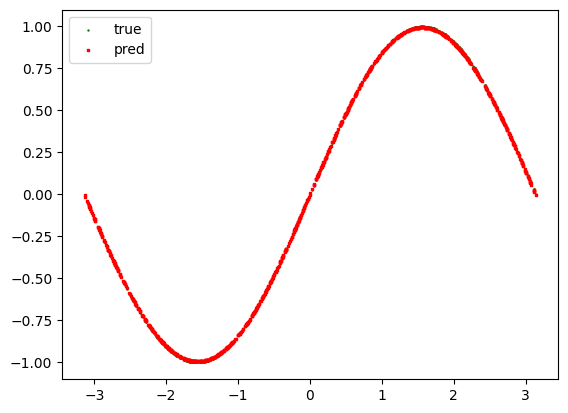

In [12]:
valid_data = np.random.uniform(-np.pi, np.pi, size=(1000, 1))
true_label = np.sin(valid_data)
pred_label = model(Tensor(valid_data, ms.float32))
plt.scatter(valid_data, true_label, color="green", s=2, marker=".")
plt.scatter(valid_data, pred_label, color="red", s=2, marker="s")
plt.legend(["true", "pred"])
plt.show()